In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [2]:
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_snPATHOseq_B208.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 47761 × 15566
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'lab_lv1_colors', 'lab_lv2_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts', 'raw'
   

In [36]:
import pandas as pd

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
    '''

    
    # Load the gene positions data
    gene_file = ("/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID version")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

#### Infer CNV

In [22]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    layer = 'raw',
    window_size=100,
    reference_key = 'dataset',
    reference_cat = ['imm', 'str']
)

# We provide immune and stromal cells as "normal cells".

  0%|          | 0/10 [00:00<?, ?it/s]

#### Cluster cells based on their CNV profile

In [23]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

In [24]:
cnv.tl.leiden(adata,resolution=0.2, n_iterations = 2)

In [25]:
cnv.tl.cnv_score(adata)

#### Plot CNV heatmaps

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


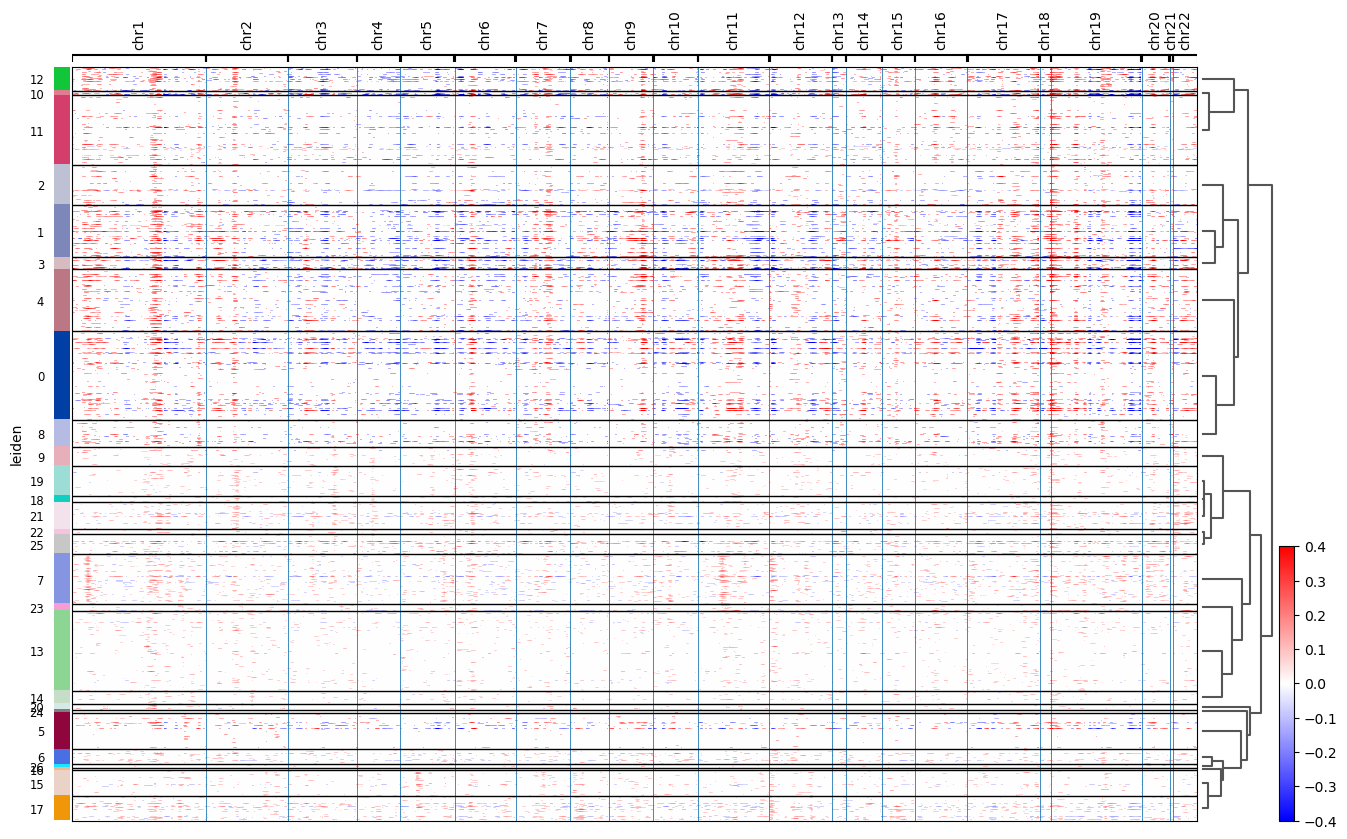

In [26]:
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True, vmax = 0.4, vmin=-0.4)

categories: epi, imm, str
var_group_labels: chr1, chr2, chr3, etc.


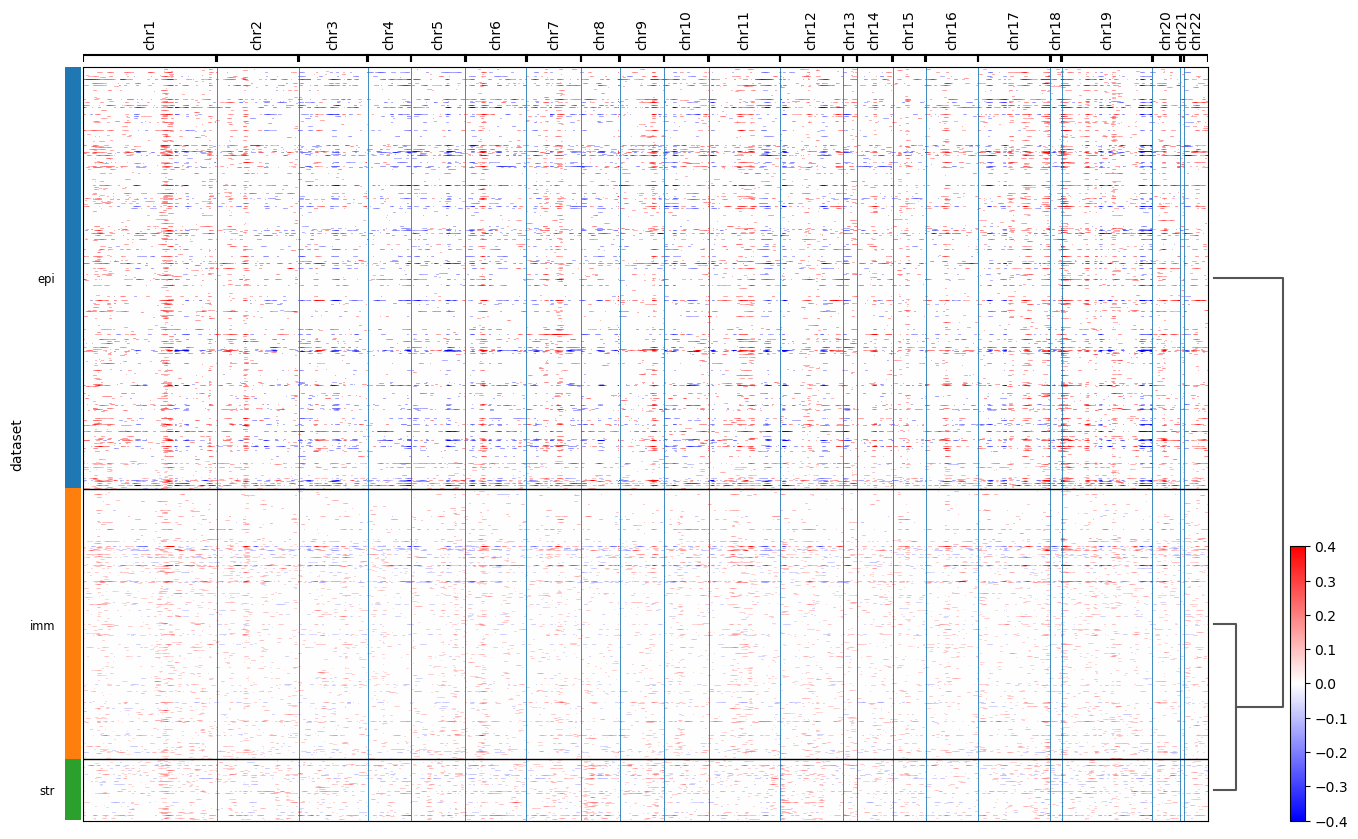

In [27]:
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True, vmax = 0.4, vmin=-0.4)

In [31]:
sc.tl.dendrogram(adata, groupby ='cnv_leiden')

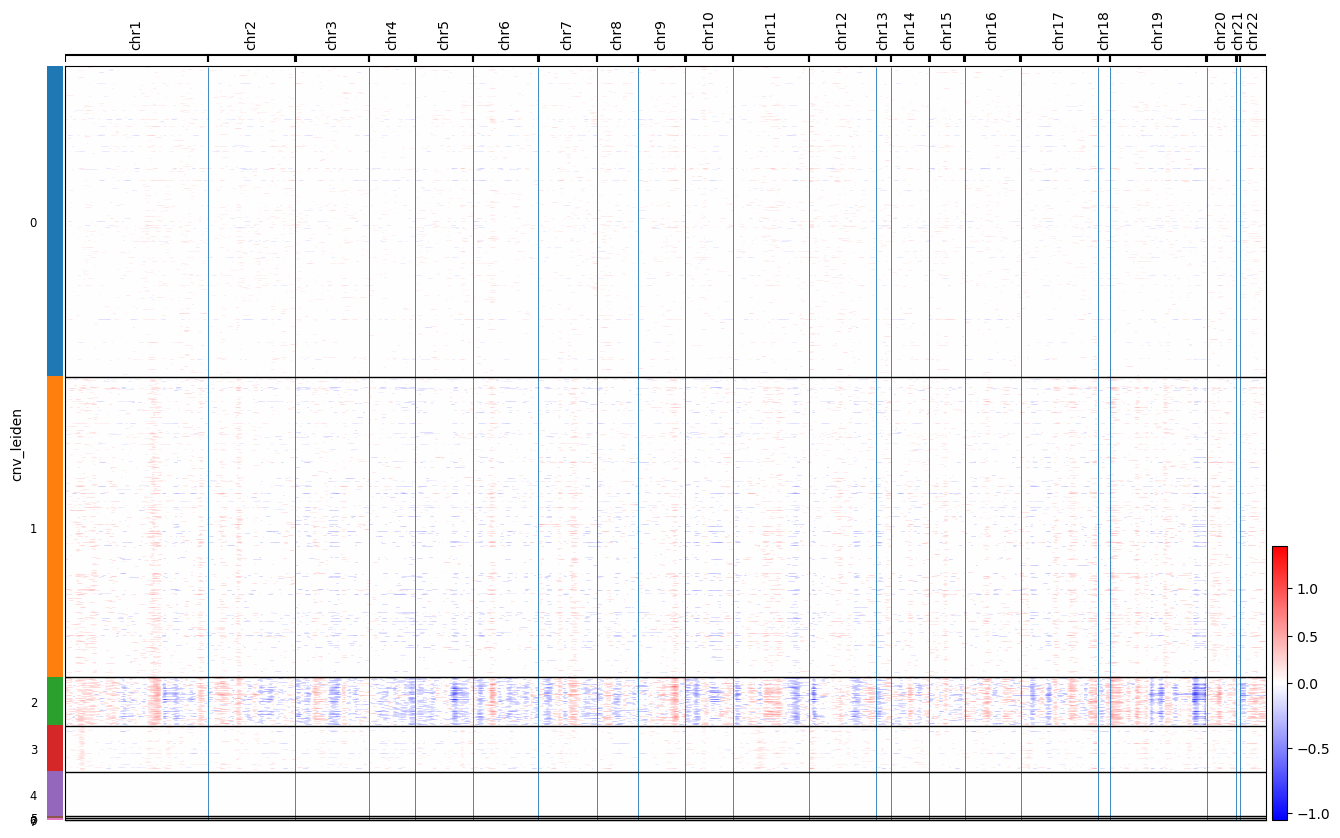

In [35]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False)

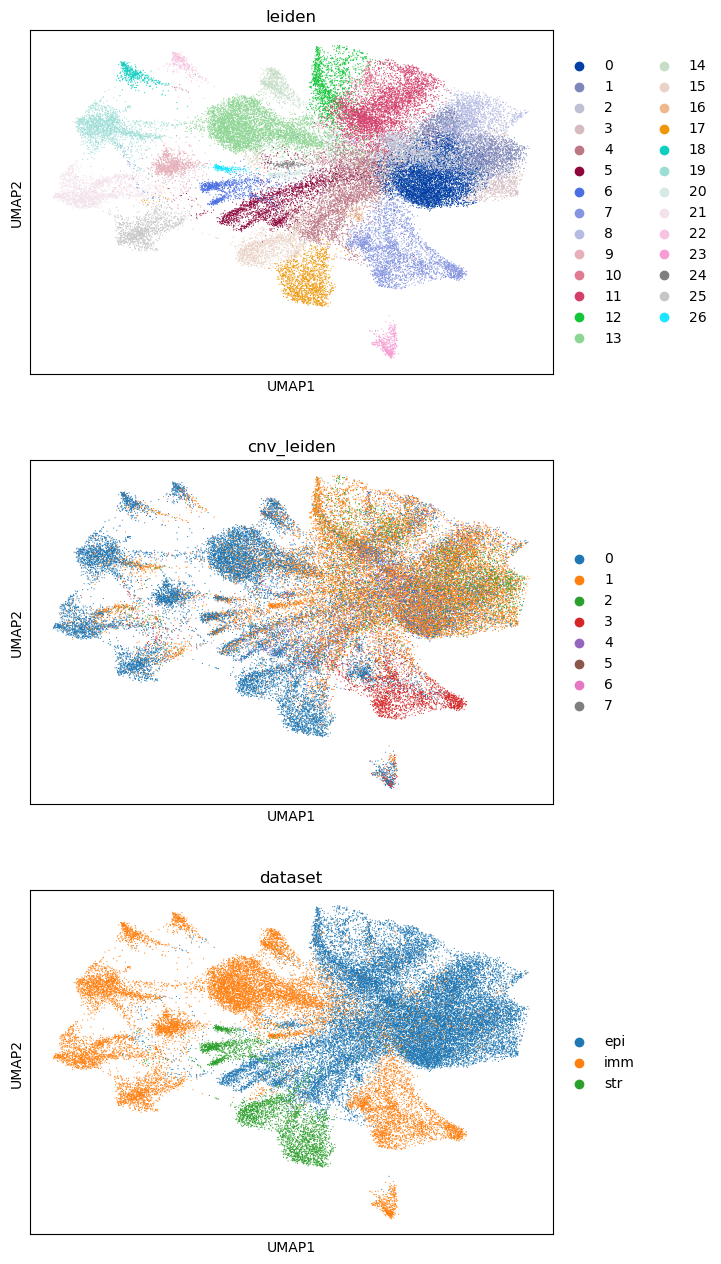

In [34]:
sc.pl.umap(adata, color = ['leiden', 'cnv_leiden', 'dataset'], ncols=1)